# Appendix — Diagnostics, Ablations, and Learning Curves

Technical deep-dive supporting the main notebook: extended diagnostics, ablations, coefficient checks, and learning curves.

## How to use this appendix

This appendix supports the main results by stress‑testing assumptions and stability.

- Residual Diagnostics: check linearity and constant variance in residuals.
- Test Error Diagnostics: ECDF, top absolute errors, and signed error vs predicted (small n → illustrative only).
- Ablations (OLS subsets): compare feature subsets; flag those within `DECISION_MARGIN` and prefer simpler when tied.
- Learning Curves: when available, show MAE/uncertainty vs sample size; if skipped, more data is needed.
- Coefficient Checks: sanity‑check signs/magnitudes and verify manual reconstruction.
- Reproducibility: library versions for reference.

### Imports

In [1]:
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
import sklearn
from IPython.display import display, Markdown
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from utils import (
    SEED as SEED_DEFAULT, N_GRID_DEFAULT, DECISION_MARGIN_DEFAULT, CV_SPLITS_A_DEFAULT, CV_SPLITS_DEFAULT, CV_REPEATS_DEFAULT, BOOT_B_DEFAULT, FEATURES,
    load_records, validate_records, plot_residuals_grid, ols_ablations, learning_curve, plot_learning_curve, coef_sanity_checks, cv_single_feature, select_best, abs_error_stats, plot_abs_error_ecdf, plot_signed_error_vs_pred, best_subset_ols,
)

### Configuration

In [2]:
# Overrides
SEED = SEED_DEFAULT
N_GRID = N_GRID_DEFAULT
DECISION_MARGIN = DECISION_MARGIN_DEFAULT
CV_SPLITS = CV_SPLITS_DEFAULT
CV_REPEATS = CV_REPEATS_DEFAULT
BOOT_B = BOOT_B_DEFAULT

### Load Data and Split

In [3]:
base = Path('..').resolve()
dataset_path = base / 'data' / 'processed' / 'datasets' / 'dataset.jsonl'
print({'dataset_path': str(dataset_path)})

df = load_records(dataset_path)
df = validate_records(df)
print(df.attrs.get('validation_info', {}))

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

{'dataset_path': '/Users/peta/Documents/dev/token-approx/data/processed/datasets/dataset.jsonl'}
{'total_before': 25, 'drops': {'input_tokens_na': 0, 'bytes_non_numeric_or_na': 0, 'runes_non_numeric_or_na': 0, 'words_non_numeric_or_na': 0, 'lines_non_numeric_or_na': 0}, 'total_after': 25}


## Residual Diagnostics

Fit OLS-best-subset on train/test and plot residual diagnostics.

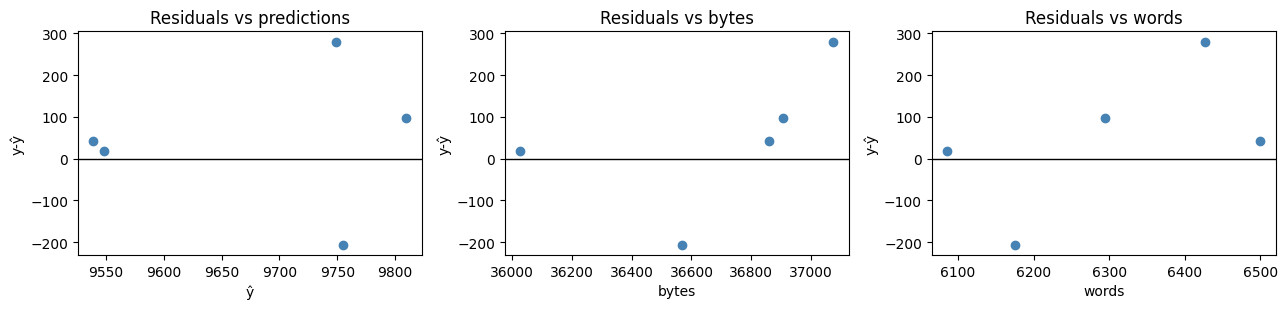

In [4]:
# Fit OLS best subset for diagnostics
res_b_ols = best_subset_ols(train_df, test_df, features=FEATURES)

yhat = res_b_ols['pred']
resid = res_b_ols['yte'] - yhat
feat_cols = res_b_ols.get('cols', []) or ['bytes', 'runes', 'words', 'lines']

_ = plot_residuals_grid(
    yhat=yhat,
    resid=resid,
    df=test_df,
    feat_cols=feat_cols,
    cols=min(3, len(feat_cols) + 1),
)

### Takeaways

- No clear residual pattern on this split; one moderate outlier.
- Sample size on test is small → treat linearity/variance conclusions as tentative.

## Test Error Diagnostics

Detailed test error views supporting the main notebook.

#### Test absolute errors (sorted)

,0,1,2,3,4
abs_err,17.600508,40.824671,97.218188,207.269282,280.296767


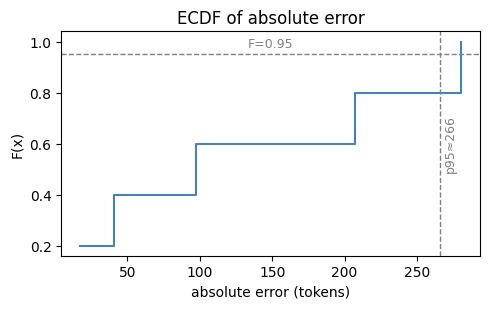

#### Test predictions and errors (sorted by abs_err)

,y_true,y_pred,signed_err,abs_err
0,10029,9748.703233,280.296767,280.296767
1,9548,9755.269282,-207.269282,207.269282
2,9907,9809.781812,97.218188,97.218188
3,9580,9539.175329,40.824671,40.824671
4,9566,9548.399492,17.600508,17.600508


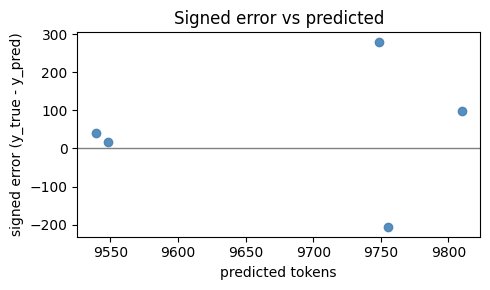

In [5]:
# Use the OLS best subset predictions computed earlier in this appendix
y_true = res_b_ols['yte']
y_pred = res_b_ols['pred']

# Absolute errors
abs_err = np.abs(y_true - y_pred)
err_df = pd.DataFrame({'abs_err': np.sort(abs_err)})
display(Markdown("#### Test absolute errors (sorted)"))
display(err_df.T)

# Compute summary numbers
stats = abs_error_stats(y_true, y_pred)
med, p95, mx, n = stats['median'], stats['p95'], stats['max'], stats['n']

# ECDF step curve
ax = plot_abs_error_ecdf(y_true, y_pred, title='ECDF of absolute error', label_refs=True)

# Signed error diagnostics table 
signed_err = y_true - y_pred
tmp = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'signed_err': signed_err,
    'abs_err': abs_err,
}).sort_values('abs_err', ascending=False).reset_index(drop=True)
display(Markdown("#### Test predictions and errors (sorted by abs_err)"))
display(tmp)

# Signed error vs predicted scatter
_ = plot_signed_error_vs_pred(y_true, y_pred, title='Signed error vs predicted')

### Takeaways
- n=5 test set → indicative only.
- On this split, median and max absolute errors provide a quick sense check; ECDF/table are included for transparency.
- We rely on train‑side repeated‑CV with bootstrap CIs for stability; collect more test samples before drawing distributional conclusions.

## Ablations (OLS Subsets)

Feature configurations are marked as `within_margin` when their MAE is within `DECISION_MARGIN` of the best MAE. Treat those as equivalently good on this dataset; prefer the simpler set unless a larger set gives a clear, robust gain.

In [6]:
features = FEATURES

# All non-empty subsets
CANDIDATES = [
    list(cols)
    for r in range(1, len(features) + 1)
    for cols in combinations(sorted(features), r)
]

abl_results = ols_ablations(train_df, test_df, CANDIDATES)
df_abl = pd.DataFrame(abl_results)
if not df_abl.empty:
    df_abl = df_abl.sort_values('mae').reset_index(drop=True)
    best_mae = df_abl['mae'].iloc[0]

    df_abl['within_margin'] = ((df_abl['mae'] - best_mae) / best_mae) <= DECISION_MARGIN

    def _bold_within_margin(row):
        return ['font-weight: bold' if bool(row['within_margin']) else '' for _ in row]

    styled = df_abl.style.apply(_bold_within_margin, axis=1)
    display(styled)
else:
    print({'ablations': 'no results'})

,cols,mae,bias,intercept,coefs,within_margin
0,"['bytes', 'words']",128.641883,45.734170,-4001.201841,"{'bytes': 0.5758117480861196, 'words': -1.1822491809479783}",True
1,"['bytes', 'runes', 'words']",131.046255,59.904726,-2610.405772,"{'bytes': 0.7328881520666659, 'runes': -0.2381400225536208, 'words': -0.968581204429918}",True
2,"['bytes', 'lines', 'runes', 'words']",140.694147,36.982616,-2789.705253,"{'bytes': 0.4767476275305158, 'lines': 2.0566415368291557, 'runes': -0.005441236064244524, 'words': -1.0124128837863848}",False
3,"['bytes', 'lines', 'words']",140.771939,36.558432,-2808.431922,"{'bytes': 0.472022931321987, 'lines': 2.0793946115798856, 'words': -1.01547003608618}",False
4,"['bytes', 'runes']",153.020134,93.339443,-3149.846818,"{'bytes': 0.8116921631312474, 'runes': -0.4754577744850986}",False
5,['runes'],154.417959,61.949713,-6864.286276,{'runes': 0.4623517853372125},False
6,['bytes'],154.600783,75.950348,-7013.629248,{'bytes': 0.45419970834349976},False
7,"['bytes', 'lines', 'runes']",154.611618,76.195700,-3312.972528,"{'bytes': 0.609438192728638, 'lines': 1.646896792144142, 'runes': -0.297719407260726}",False
8,"['bytes', 'lines']",156.455110,56.226054,-4639.179627,"{'bytes': 0.32704267646165747, 'lines': 3.0520632217181354}",False
9,"['lines', 'runes']",158.185256,33.700029,-4553.863149,"{'lines': 4.990709286666581, 'runes': 0.2928297823240975}",False


### Takeaways

- Best subset on this split: bytes+words.
- bytes+runes+words is within the decision margin (but prefer the simpler set unless a robust gain appears).

## Learning Curves

Learning curves for A (selected single feature) and B (OLS 4 features).

Curves are computed only when `N_GRID` points do not exceed the available training size. When skipped on small datasets, interpret this as "insufficient sample sizes to form a meaningful curve"; with more data, expect MAE to decrease and variance bands to tighten as `n` grows.

{'learning_curve_feature_B': ('bytes', 'words')}
{'cv_splits_lc': 5, 'cv_repeats': 5}
{'learning_curve_feature_A': 'bytes', 'fit_intercept_A': True}


,n,A_mae,A_lo,A_hi,B_mae,B_lo,B_hi,A_rel_hw,B_rel_hw
0,5,252.739584,191.128193,324.533516,180.627420,149.553283,217.115621,0.006921,0.003505
1,10,196.616322,152.510422,244.352129,181.121847,135.912631,228.672915,0.004765,0.004812
2,15,180.979082,148.333540,214.662164,163.735154,135.159423,193.943243,0.003441,0.003050
3,20,166.039782,137.973713,192.805772,144.212212,122.907007,165.785021,0.002845,0.002225


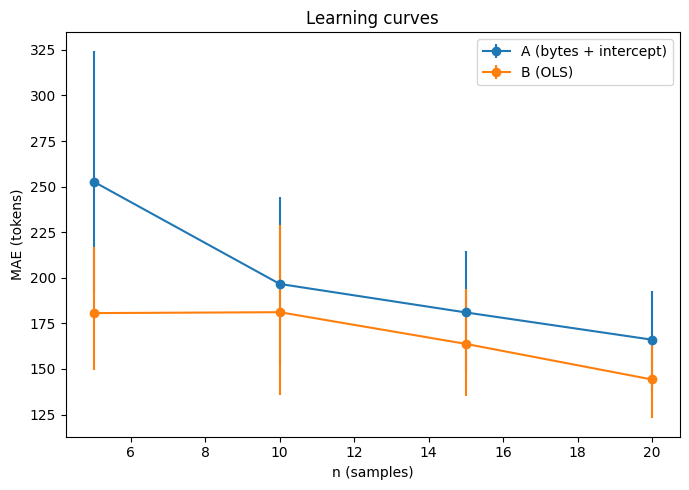

In [7]:
features_list = FEATURES
rows = []
for feat in features_list:
    Xtr_feat = train_df[[feat]].to_numpy()
    ytr = train_df['input_tokens'].to_numpy()
    for fi in (False, True):
        mae_cv, bias_cv = cv_single_feature(Xtr_feat, ytr, fit_intercept=fi, n_splits=CV_SPLITS_A_DEFAULT, seed=SEED)
        rows.append({'feature': feat, 'fit_intercept': fi, 'cv_mae': mae_cv, 'cv_bias': bias_cv})
cv_df = pd.DataFrame(rows).sort_values(['cv_mae', 'feature', 'fit_intercept']).reset_index(drop=True)
best_cv = select_best(cv_df)
feat = best_cv['feature']
fi = bool(best_cv['fit_intercept'])

# Pre-filter N_GRID
N_GRID_filtered = [int(n) for n in N_GRID if int(n) <= len(train_df)]
if not N_GRID_filtered:
    print({'learning_curves': 'skipped', 'reason': 'n_grid > len(train_df)', 'len_train_df': int(len(train_df)), 'N_GRID': list(N_GRID)})
    display(Markdown("Learning curves skipped (grid > train size). With more data, expect MAE to decrease and confidence bands to tighten."))
else:
    # Determine feature_B for learning curve: use best subset from ablations if available
    if 'df_abl' in globals() and isinstance(df_abl, pd.DataFrame) and not df_abl.empty and 'cols' in df_abl.columns:
        feature_B_cols = tuple(df_abl.loc[0, 'cols'])
    else:
        feature_B_cols = ('bytes','runes','words','lines')
    print({'learning_curve_feature_B': feature_B_cols})
    # Ensure CV splits are valid for the smallest n in the grid
    cv_splits_lc = max(2, min(CV_SPLITS, min(N_GRID_filtered)))
    print({'cv_splits_lc': cv_splits_lc, 'cv_repeats': CV_REPEATS})
    lc_df = learning_curve(
        train_df,
        n_grid=N_GRID_filtered,
        feature_A=(feat,),
        feature_B=feature_B_cols,
        seed=SEED,
        cv_splits=cv_splits_lc,
        cv_repeats=CV_REPEATS,
        boot_B=BOOT_B,
        fit_intercept_A=fi,
    )
    print({'learning_curve_feature_A': feat, 'fit_intercept_A': fi})

    if lc_df is not None and not lc_df.empty:
        display(lc_df)
        ax = plot_learning_curve(lc_df)
        ax.set_title(f'Learning curves with {cv_splits_lc}x{CV_REPEATS} CV and bootstrap CIs')
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ['A (bytes + intercept)', f'B (OLS: {",".join(feature_B_cols)})'])
    else:
        print({'learning_curves': 'skipped_or_empty'})

### Takeaways

- MAE decreases for both A and B as n increases, consistent with expected learning behaviour.

## Coefficient Checks

Sanity flags on best B model and coefficient recovery demos.

In [8]:
# Determine best subset
best_cols = None
best_res = None

# Prefer the ablations table if it exists
if 'df_abl' in globals() and isinstance(df_abl, pd.DataFrame) and not df_abl.empty:
    best_cols = df_abl.loc[0, 'cols'] if 'cols' in df_abl.columns else None

# Fallback: recompute best subset by test MAE
if best_cols is None:
    features = FEATURES
    best_mae = np.inf
    for r in range(1, len(features) + 1):
        for cols in combinations(sorted(features), r):
            Xtr = train_df[list(cols)].to_numpy()
            ytr = train_df['input_tokens'].to_numpy()
            Xte = test_df[list(cols)].to_numpy()
            yte = test_df['input_tokens'].to_numpy()
            lr = LinearRegression(fit_intercept=True)
            lr.fit(Xtr, ytr)
            pte = lr.predict(Xte)
            mae = float(np.mean(np.abs(yte - pte)))
            if mae < best_mae:
                best_mae = mae
                best_res = {
                    'cols': list(cols),
                    'intercept': float(lr.intercept_),
                    'coefs': dict(zip(list(cols), map(float, lr.coef_))),
                    'pred': pte,
                }
    best_cols = best_res['cols']
    intercept = best_res['intercept']
    coefs = best_res['coefs']
    pred = best_res['pred']
else:
    # Refit on best_cols to capture exact coefficients and predictions
    Xtr = train_df[best_cols].to_numpy()
    ytr = train_df['input_tokens'].to_numpy()
    Xte = test_df[best_cols].to_numpy()
    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xtr, ytr)
    pred = lr.predict(Xte)
    intercept = float(lr.intercept_)
    coefs = dict(zip(best_cols, map(float, lr.coef_)))

print({'best_subset_cols': best_cols})

flags = coef_sanity_checks(coefs)
print({'ols_subset_flags': flags})

coef_order = sorted(coefs.keys())
Xte = test_df[coef_order].to_numpy()
coef_vec = np.array([coefs[k] for k in coef_order], dtype=float)
manual_pred = intercept + Xte @ coef_vec
ok = np.allclose(manual_pred, pred, atol=1e-6)
max_diff = float(np.max(np.abs(manual_pred - pred)))
print({'ols_subset_coef_recovery_check': bool(ok), 'max_abs_diff': max_diff})

{'best_subset_cols': ['bytes', 'words']}
{'ols_subset_flags': {'negative_bytes': False, 'negative_runes': False, 'notes': []}}
{'ols_subset_coef_recovery_check': True, 'max_abs_diff': 0.0}


### Takeaways

- Sanity flags are clear; manual reconstruction matches predictions.
- Linear model behavior verified on this split.

## Reproducibility

Library versions for reference (see below).

In [9]:
import platform

display(Markdown(f"""Library versions:\n{'\n'.join([f'- {k}: {v}' for k, v in {'python': platform.python_version(), 'numpy': np.__version__, 'pandas': pd.__version__, 'sklearn': sklearn.__version__}.items()])}"""))

Library versions:
- python: 3.13.5
- numpy: 2.3.4
- pandas: 2.3.3
- sklearn: 1.7.2